# Проект: Обучение с учителем: качество модели

<b>Описание проекта</b>
<p>
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
</p>

**Цель:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

<b>Задачи:</b>
<ol>
<li>Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца</li>
<li>Выделить сегмент покупателей и предложить, как увеличить его покупательскую активность за счет персонализированных предложений</li>
</ol>

<b>Исходные данные:</b>
<ol>
<li>Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении</li>
<li>Данные о выручке, которую получает магазин с покупателя за период взаимодействия с сайтом</li>
<li>Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода</li>
<li>Данные о среднемесячной прибыли покупателя за последние 3 месяца</li>
</ol>

## Подключение необходимых библиотек

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install pandas==1.5.0 -q
!pip install shap -q
!pip install phik -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
import shap
import phik

## Загрузка данных

Прочитаем исходные данные из файлов

In [3]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
market_file_data= pd.read_csv(datasets_path+'market_file.csv', sep=',')
market_money_data= pd.read_csv(datasets_path+'market_money.csv', sep=',')
market_time_data= pd.read_csv(datasets_path+'market_time.csv', sep=',')
money_data= pd.read_csv(datasets_path+'money.csv', sep=';', decimal = ',')

##  Предобработка данных

Выведем общую информацию и первые 5 строк файла market_file_data.csv для контроля загрузки и первого знакомства с данными

In [4]:
print(market_file_data.info())
market_file_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Выведем общую информацию и первые 5 строк файла market_money_data.csv для контроля загрузки и первого знакомства с данными

In [5]:
print(market_money_data.info())
market_money_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Выведем общую информацию и первые 5 строк файла market_time_data.csv для контроля загрузки и первого знакомства с данными

In [6]:
print(market_time_data.info())
market_time_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Выведем общую информацию и первые 5 строк файла money_data.csv для контроля загрузки и первого знакомства с данными

In [7]:
print(money_data.info())
money_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Обработка пропусков и дубликатов, замена типов данных (если потребуется)

#### Проанализируем количество пропусков в данных по столбцам: результаты загрузки файлов в датафремы выше (info()) показали, что пропусков в данных не обнаружено

#### Поиск и удаление явных дубликатов

In [8]:
market_file_data.duplicated().sum()

0

In [9]:
market_money_data.duplicated().sum()

0

In [10]:
market_time_data.duplicated().sum()

0

In [11]:
money_data.duplicated().sum()

0

**Вывод: явные дубликаты не найдены**

#### Поиск неявных дубликатов для значений, заданных строками-перечислениями

In [12]:
for column in market_file_data.select_dtypes(exclude='number').columns.tolist():
    print(sorted(market_file_data[column].unique()))

['Прежний уровень', 'Снизилась']
['премиум', 'стандарт', 'стандартт']
['да', 'нет']
['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']


In [13]:
for column in market_money_data.select_dtypes(exclude='number').columns.tolist():
    print(sorted(market_money_data[column].unique()))

['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']


In [14]:
for column in market_time_data.select_dtypes(exclude='number').columns.tolist():
    print(sorted(market_time_data[column].unique()))

['предыдцщий_месяц', 'текущий_месяц']


Замена значений периода 'предыдцщий_месяц' на 'предыдущий_месяц' для market_time_data (то же значение, что и в market_money_data)

In [15]:
market_time_data['Период']= market_time_data['Период'].replace('предыдцщий_месяц','предыдущий_месяц')
sorted(market_time_data['Период'].unique())

['предыдущий_месяц', 'текущий_месяц']

Замена значений 'тип сервиса'= "стандартт" на "стандарт"

In [16]:
market_file_data['Тип сервиса']= market_file_data['Тип сервиса'].replace('стандартт','стандарт')
sorted(market_file_data['Тип сервиса'].unique())

['премиум', 'стандарт']

**Вывод: неявные дубликаты не найдены. Строки-перечисления приведены к единообразному виду.**

## Исследовательский анализ данных

#### Изучим числовые характеристики исходных данных о поведении на сайте, коммуникациях с клиентом и продуктовом поведении

In [17]:
market_file_data.describe() 

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


#### Анализ распределения значений признаков

**Анализ распределения значений признаков для характертистик коммуникации сотрудников компании с клиентом**

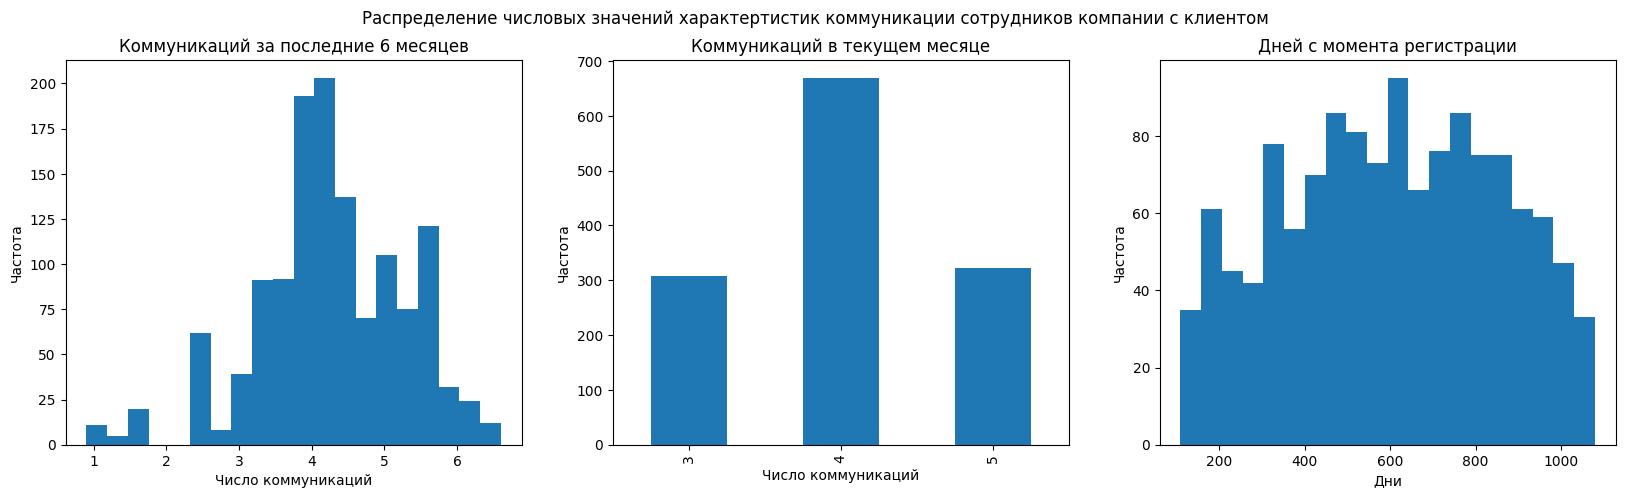

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение числовых значений характертистик коммуникации сотрудников компании с клиентом')
market_file_data['Маркет_актив_6_мес'].plot(
ax=ax1,
bins=20,
kind='hist',
title='Коммуникаций за последние 6 месяцев')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Число коммуникаций')
market_file_data.groupby('Маркет_актив_тек_мес')['Маркет_актив_тек_мес'].count().plot(
ax=ax2,
kind='bar',
title='Коммуникаций в текущем месяце')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Число коммуникаций')
market_file_data['Длительность'].plot(
ax=ax3,
bins=20,
kind='hist',
title='Дней с момента регистрации')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Дни')
plt.show()

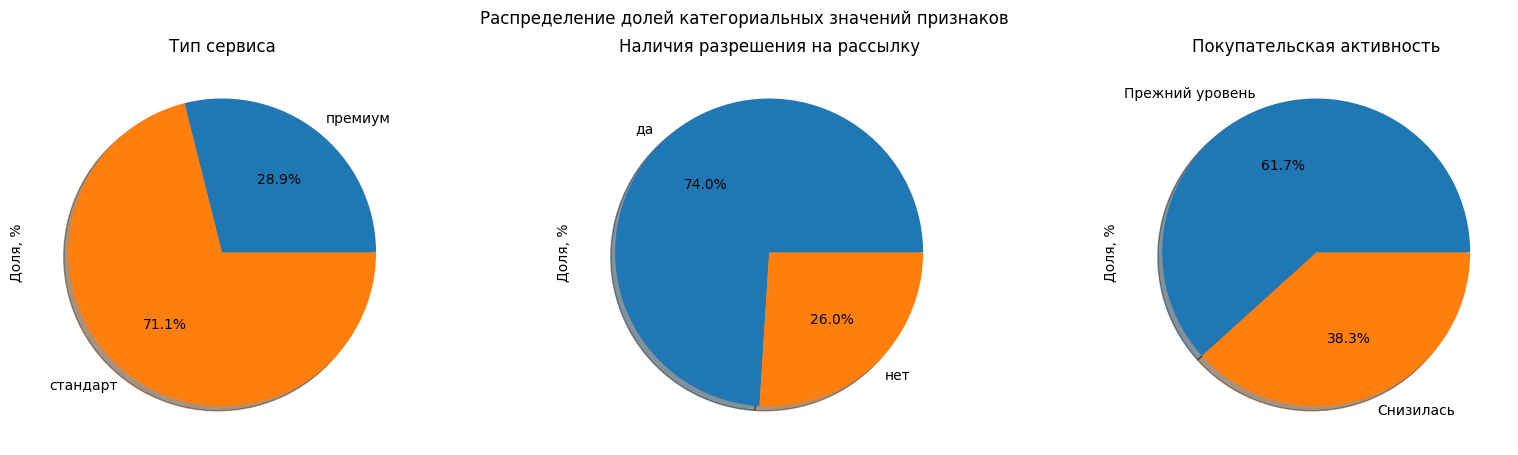

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение долей категориальных значений признаков')
market_file_data.groupby('Тип сервиса')['Тип сервиса'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Тип сервиса')
market_file_data.groupby('Разрешить сообщать')['Разрешить сообщать'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Наличия разрешения на рассылку')
market_file_data.groupby('Покупательская активность')['Покупательская активность'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Покупательская активность')
plt.show()

Ящик с усами для численных характеристик коммуникаций с клиентом

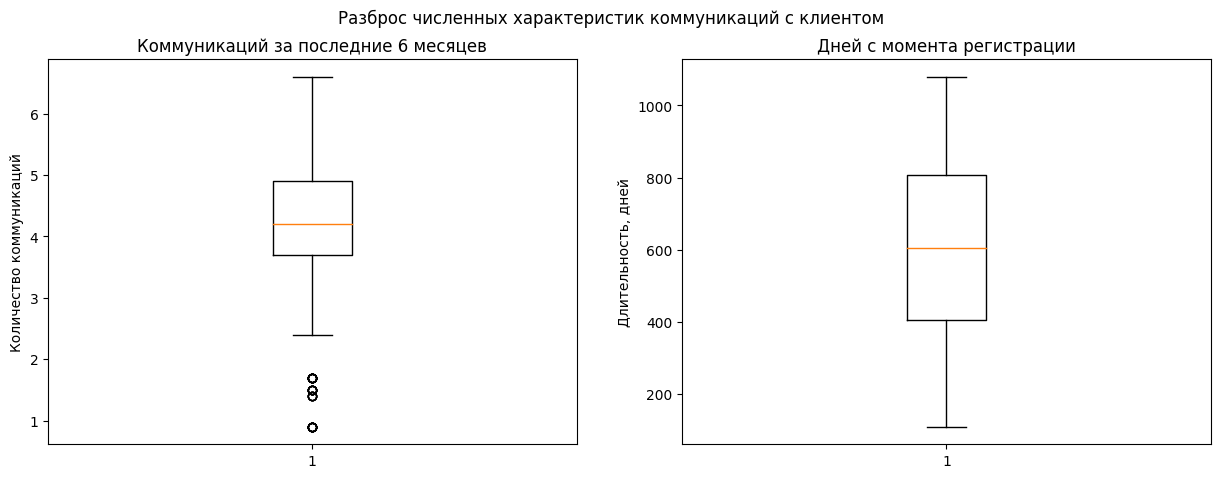

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Разброс численных характеристик коммуникаций с клиентом')
axes[0].boxplot(market_file_data['Маркет_актив_6_мес'])
axes[0].set_title('Коммуникаций за последние 6 месяцев')
axes[0].set_ylabel('Количество коммуникаций')
axes[1].boxplot(market_file_data['Длительность']) 
axes[1].set_ylabel('Длительность, дней')
axes[1].set_title('Дней с момента регистрации')
plt.show()

Вычислим, сколько значений числа коммуникаций за последние 6 месяцев за пределами нижней границы усов

In [21]:
def get_lower_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.25] - 1.5*iqr
def get_lower_values_cnt(df, char_name):
    lower_level= get_lower_mustache(df, char_name)
    return df[df[char_name]<lower_level][char_name].count()

In [22]:
anomal_values_cnt=get_lower_values_cnt(market_file_data, 'Маркет_актив_6_мес')
display(f'Количество значений ниже нижней границы: {anomal_values_cnt}')
display(f'Значений в % от общего объема выборки: {round(100*anomal_values_cnt/len(market_file_data),2)}')

'Количество значений ниже нижней границы: 36'

'Значений в % от общего объема выборки: 2.77'

**Выводы: распределение числовых признаков близко к нормальному. При этом для признака "количество коммуникаций" имеется всего 3 значения, то есть этот признак можно считать ранговым (так как возрастание значений имеет смысл). Выбросы в данных по коммуникации с клиентами за последние 6 месяцев удалены, другие корректировки не требуются**

#### Анализ распределения значений признаков для характертистик продуктового поведения клиентов

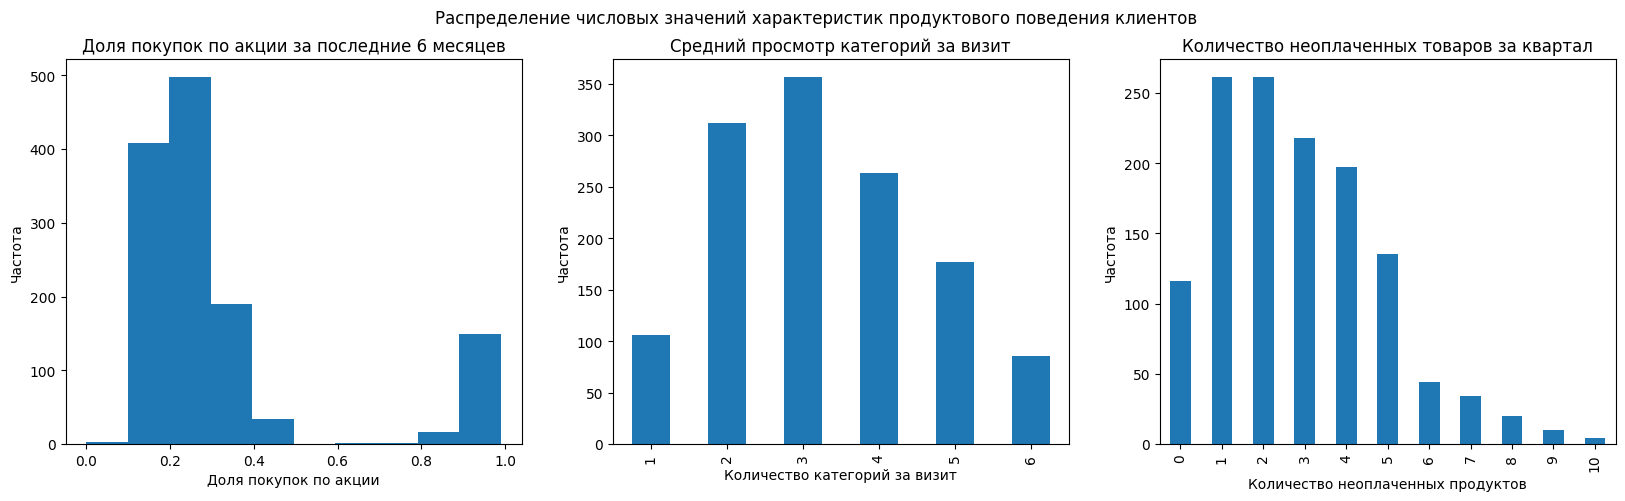

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение числовых значений характеристик продуктового поведения клиентов')
market_file_data['Акционные_покупки'].plot(
ax=ax1,
kind='hist',
title='Доля покупок по акции за последние 6 месяцев')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Доля покупок по акции')
market_file_data.groupby('Средний_просмотр_категорий_за_визит')['Средний_просмотр_категорий_за_визит'].count().plot(
ax=ax2,
kind='bar',
title='Средний просмотр категорий за визит')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Количество категорий за визит')
market_file_data.groupby('Неоплаченные_продукты_штук_квартал')['Неоплаченные_продукты_штук_квартал'].count().plot(
ax=ax3,
kind='bar',
title='Количество неоплаченных товаров за квартал')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Количество неоплаченных продуктов')
plt.show()

Ящик с усами для численных характеристик продуктового поведения клиентов

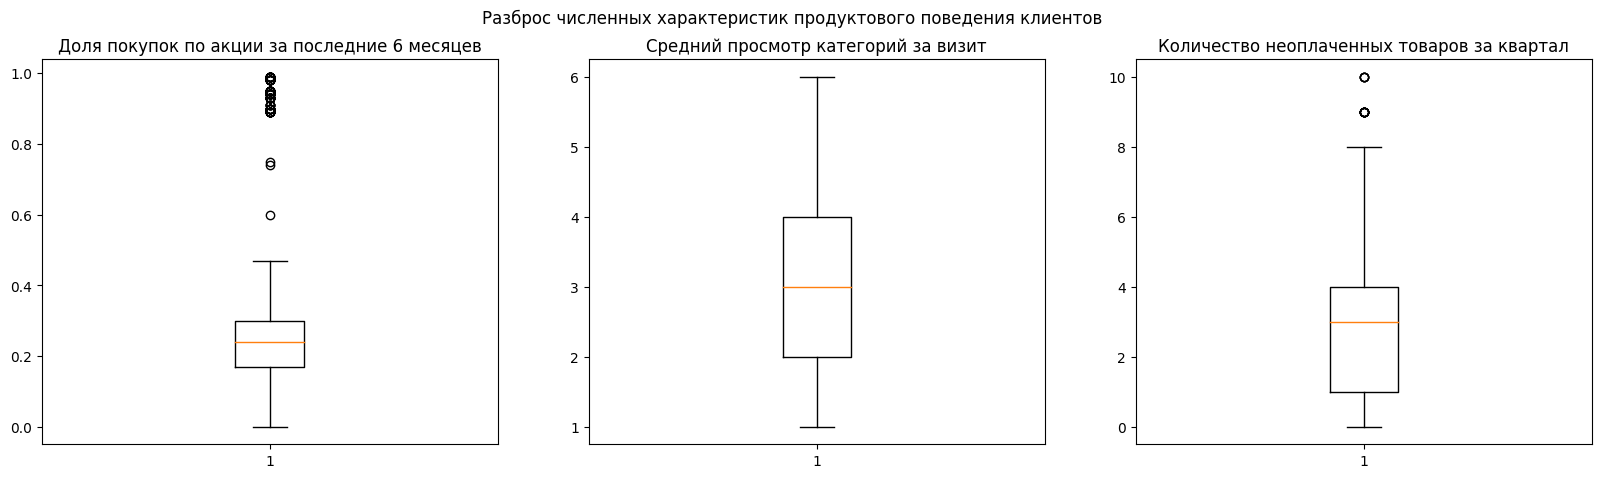

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Разброс численных характеристик продуктового поведения клиентов')
axes[0].boxplot(market_file_data['Акционные_покупки'])
axes[1].boxplot(market_file_data['Средний_просмотр_категорий_за_визит']) 
axes[2].boxplot(market_file_data['Неоплаченные_продукты_штук_квартал']) 
axes[0].set_title('Доля покупок по акции за последние 6 месяцев')
axes[1].set_title('Средний просмотр категорий за визит')
axes[2].set_title('Количество неоплаченных товаров за квартал')
plt.show()

Определим численно, сколько значений за верхней границей усов для признаков "Доля покупок по акции" и "Количество неоплаченных товаров за квартал"

In [25]:
def get_upper_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.75] + 1.5*iqr
def get_upper_values_cnt(df, char_name):
    upper_level= get_upper_mustache(df, char_name)
    return df[df[char_name]>upper_level][char_name].count()

In [26]:
anomal_values_cnt=get_upper_values_cnt(market_file_data, 'Акционные_покупки')
display(f'Количество аномальных значений признака "доля покупок по акции" составляет {anomal_values_cnt}')
display(f'то есть {round(100*anomal_values_cnt/len(market_file_data), 2)}% данных')#значение в % от общего объема выборки

'Количество аномальных значений признака "доля покупок по акции" составляет 168'

'то есть 12.92% данных'

Выбросы для доли покупок по акции составляют большую часть данных, не станем удалять значения

In [27]:
anomal_values_cnt=get_upper_values_cnt(market_file_data, 'Неоплаченные_продукты_штук_квартал')
display(f'Количество аномальных значений признака "количество неоплаченных товаров за квартал" составляет {anomal_values_cnt}')
display(f'то есть {round(100*anomal_values_cnt/len(market_file_data), 2)}% данных')#значение в % от общего объема выборки

'Количество аномальных значений признака "количество неоплаченных товаров за квартал" составляет 14'

'то есть 1.08% данных'

Удалим значения выбросов для признака "количество неоплаченных товаров за квартал"

In [28]:
market_file_data= market_file_data[market_file_data['Неоплаченные_продукты_штук_квартал']< 
    get_upper_mustache(market_file_data, 'Неоплаченные_продукты_штук_квартал')]
anomal_values_cnt=get_lower_values_cnt(market_file_data, 'Неоплаченные_продукты_штук_квартал')
display(f'Число аномальных значений для признака "количество неоплаченных товаров за квартал:" {anomal_values_cnt}')

'Число аномальных значений для признака "количество неоплаченных товаров за квартал:" 0'

**Выводы: данные о покупках по акции и количеству неоплаченных товаров распределены не по нормальному закону распределения, нельзя применять коэффициент корреляции пирсона и тп методы анализа нормально распределенных данных. Небольшое количество выбросов в данных по неоплаченным заказам удалено, выбросы для доли покупок по акции составляют большую часть данных, не станем удалять значения**

#### Проанализируем категориальные признаки, относящиеся к продуктовому поведению

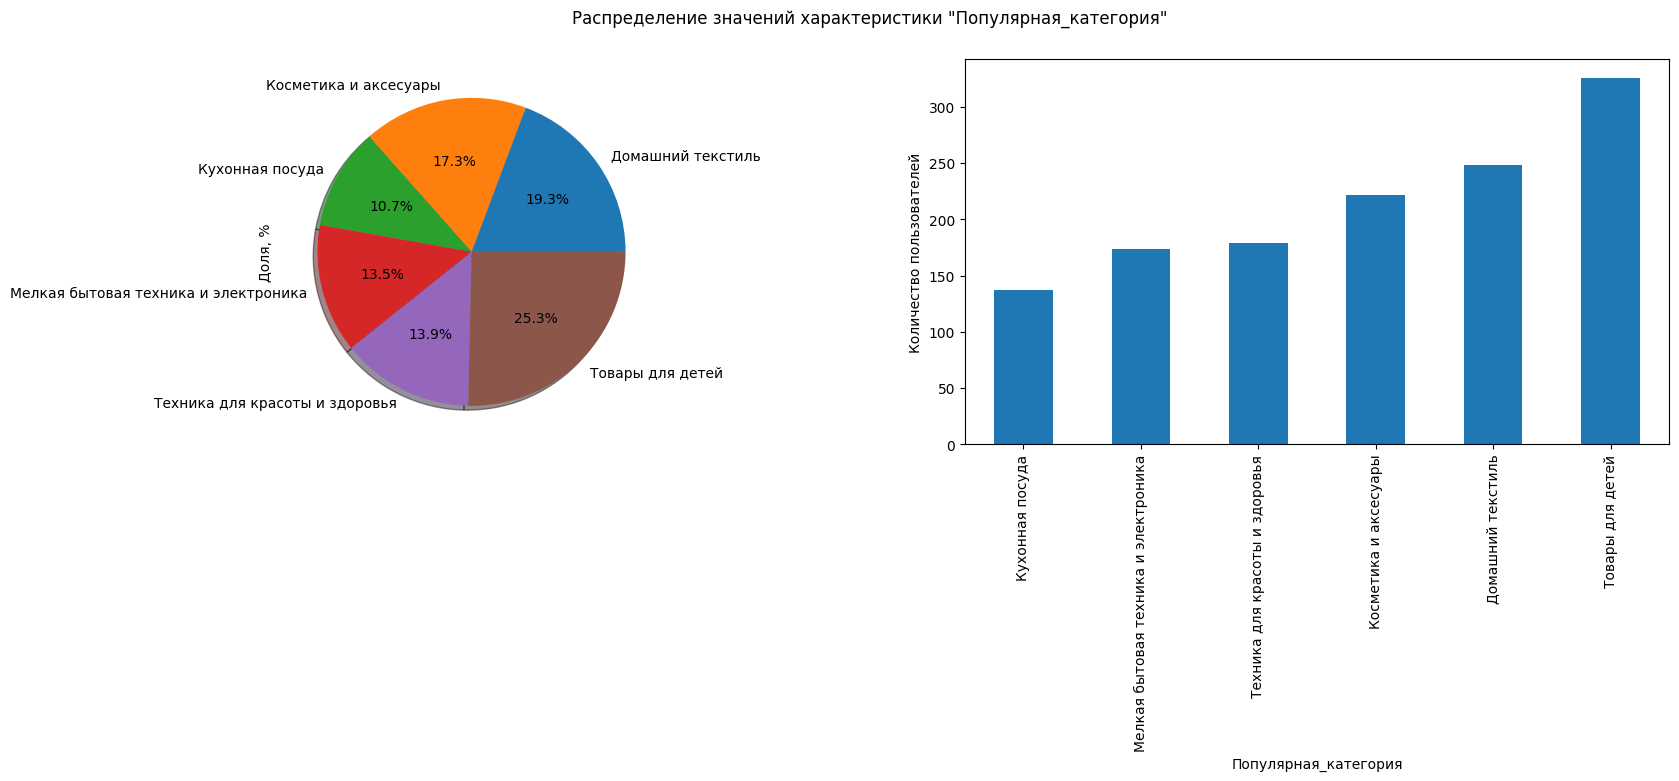

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Распределение значений характеристики "Популярная_категория"')
market_file_data.groupby('Популярная_категория')['Популярная_категория'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %')
market_file_data.groupby('Популярная_категория')['Популярная_категория'].count().sort_values().plot(
ax=ax2,
kind='bar',
ylabel='Количество пользователей')
plt.show()

**Вывод: распределение долей по категориям относительно ровное, но категории "домашний текстиль" и "товары для детей" популярны почти у половины (45%) пользователей**

#### Анализ распределения значений характеристик поведения на сайте

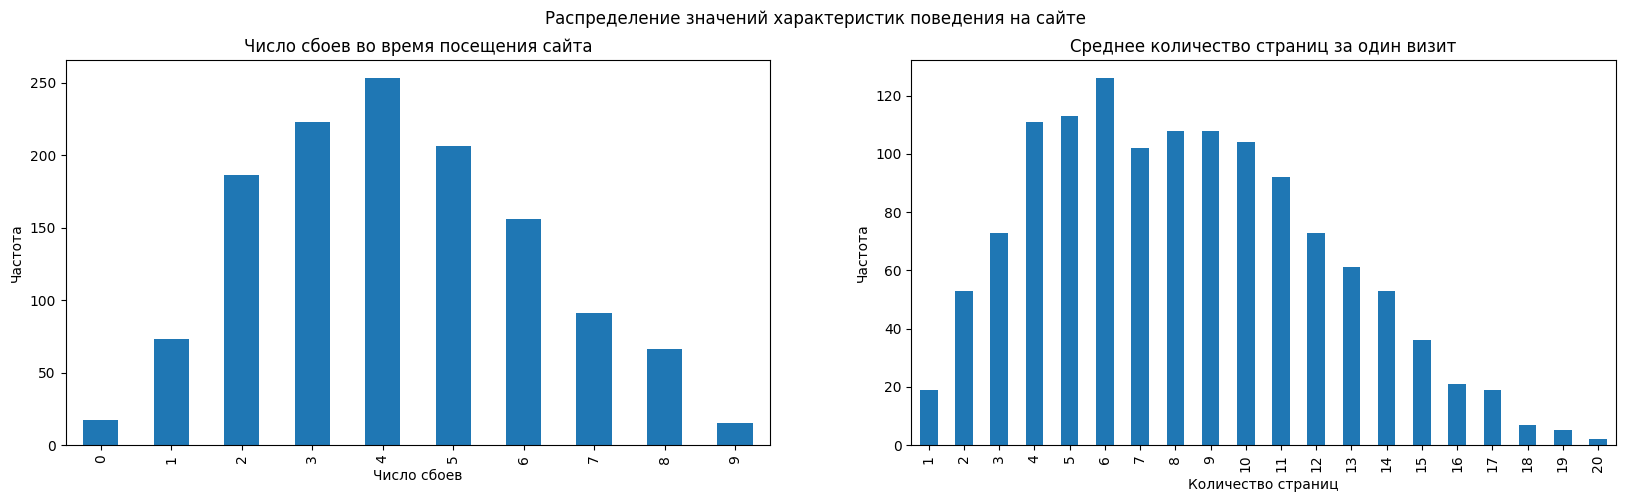

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Распределение значений характеристик поведения на сайте')
market_file_data.groupby('Ошибка_сервиса')['Ошибка_сервиса'].count().plot(
ax=ax1,
kind='bar',
title='Число сбоев во время посещения сайта')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Число сбоев')
market_file_data.groupby('Страниц_за_визит')['Страниц_за_визит'].count().plot(
ax=ax2,
kind='bar',
title='Среднее количество страниц за один визит')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Количество страниц')
plt.show()

Ящик с усами для характеристик поведения на сайте

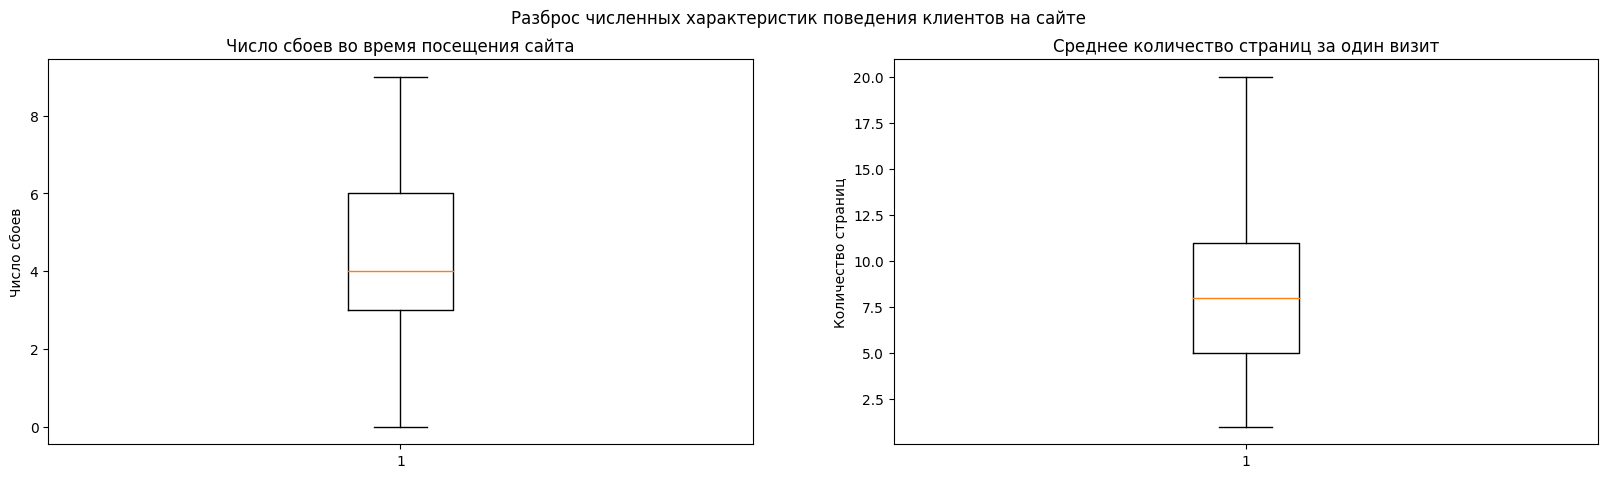

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Разброс численных характеристик поведения клиентов на сайте')
axes[0].boxplot(market_file_data['Ошибка_сервиса'])
axes[0].set_title('Число сбоев во время посещения сайта')
axes[0].set_ylabel('Число сбоев')
axes[1].boxplot(market_file_data['Страниц_за_визит']) 
axes[1].set_title('Среднее количество страниц за один визит')
axes[1].set_ylabel('Количество страниц')
plt.show()

**Выводы: Распределение частоты значений признаков близко к нормальному, можно использовать коэффициент коррелияции пирсона и тп методы для нормально распределенных данных. Выбросы в данных не обнаружены, корректировка данных на первый взгляд не требуется.** 

#### Анализ распределения значений данных о выручке

In [32]:
market_money_data.describe() 

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


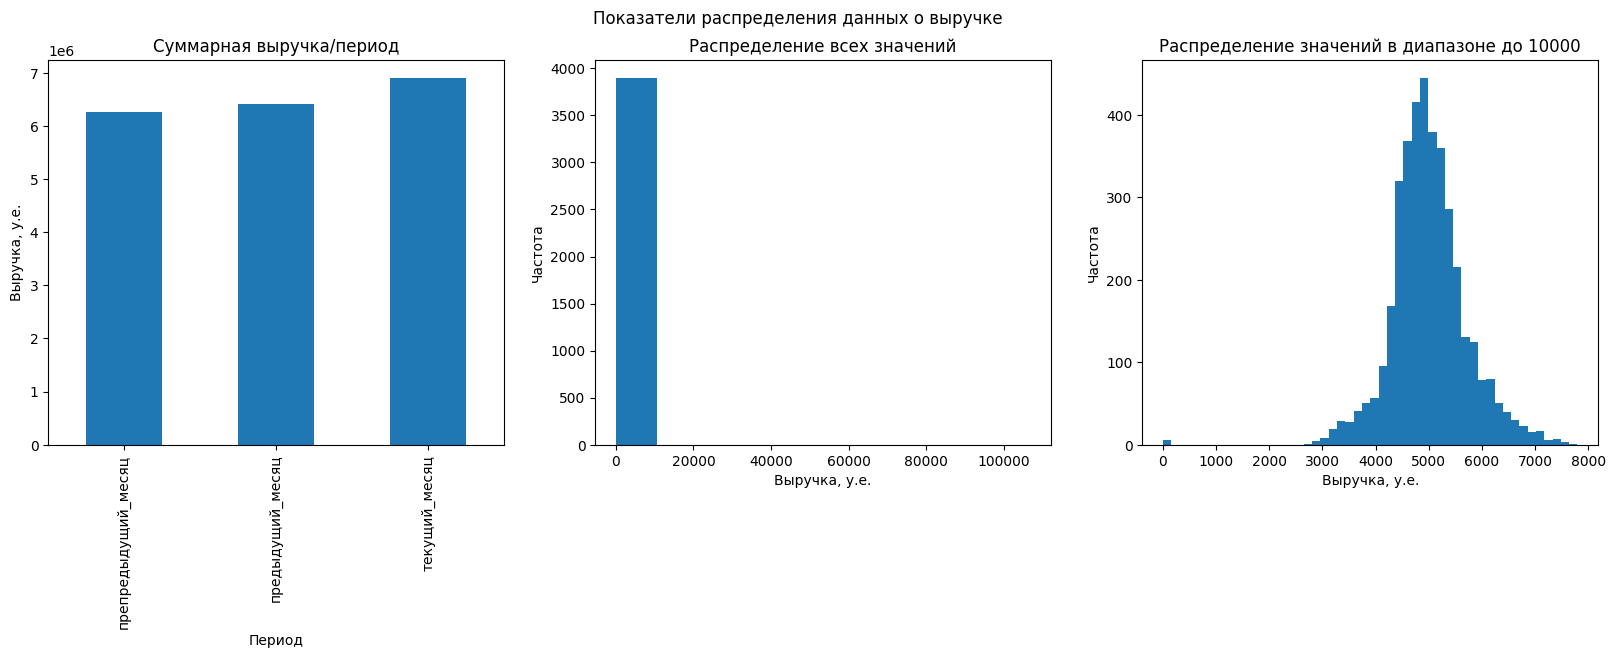

In [33]:
normal_income= market_money_data.query('Выручка<10000')['Выручка']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Показатели распределения данных о выручке')
market_money_data.groupby('Период')['Выручка'].sum().sort_values().plot(
kind='bar',
ax=ax1,
title='Cуммарная выручка/период')
ax1.set_ylabel('Выручка, у.е.')
ax1.set_xlabel('Период')
market_money_data['Выручка'].plot(
kind='hist',
ax=ax2,
title='Распределение всех значений')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Выручка, у.е.')
normal_income.plot(
kind='hist',
ax=ax3,
bins=50,
title='Распределение значений в диапазоне до 10000')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Выручка, у.е.')
plt.show()

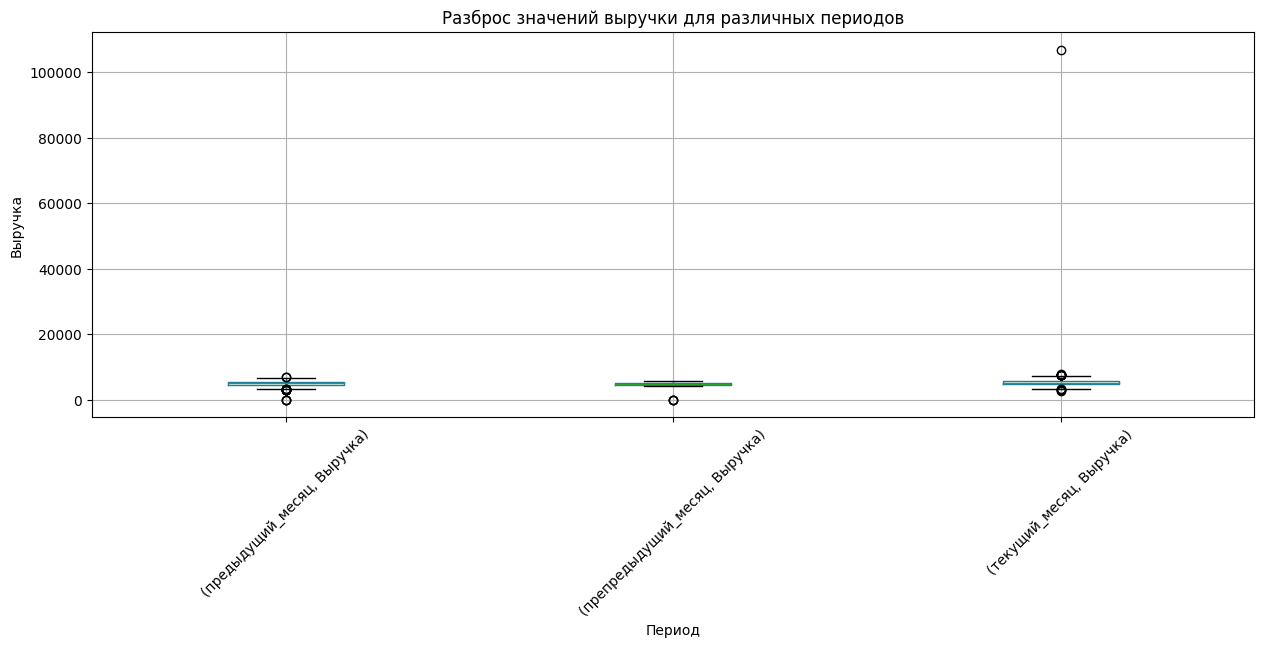

In [34]:
market_money_data.groupby('Период').boxplot(
subplots=False,
column='Выручка', 
rot=45,
figsize=(15,5))
plt.ylabel('Выручка')
plt.xlabel('Период')
plt.title('Разброс значений выручки для различных периодов')
plt.show()

Для текущего месяца есть выбросы, существенно выбивающиеся из общей картины, выясним сколько их

In [35]:
df_current= market_money_data[market_money_data['Период']=='текущий_месяц']
null_income_cnt= market_money_data[market_money_data['Выручка']==0]['id'].count()
anomal_values_upper_cnt=get_upper_values_cnt(df_current, 'Выручка')
anomal_values_lower_cnt=get_lower_values_cnt(df_current, 'Выручка')
display(f'Всего записей о выручке: {len(market_money_data)}')
display(f'Количество аномальных значений признака "Выручка" за текущий месяц составляет {anomal_values_upper_cnt}')
display(f'то есть {round(100*anomal_values_upper_cnt/len(market_file_data), 2)}% данных')#значение в % от общего объема выборки
display(f'Значений с нулевой выручкой: {null_income_cnt}')
display(f'то есть {round(100*null_income_cnt/len(market_file_data), 2)}% данных')#значение в % от общего объема выборки

'Всего записей о выручке: 3900'

'Количество аномальных значений признака "Выручка" за текущий месяц составляет 11'

'то есть 0.86% данных'

'Значений с нулевой выручкой: 6'

'то есть 0.47% данных'

Удалим выбросы (запредельная выручка для текущего месяца и нулевая выручка - так как в сумме этих значений менее 1,5% данных) и заново построим ящик с усами

'Всего записей о выручке: 3883'

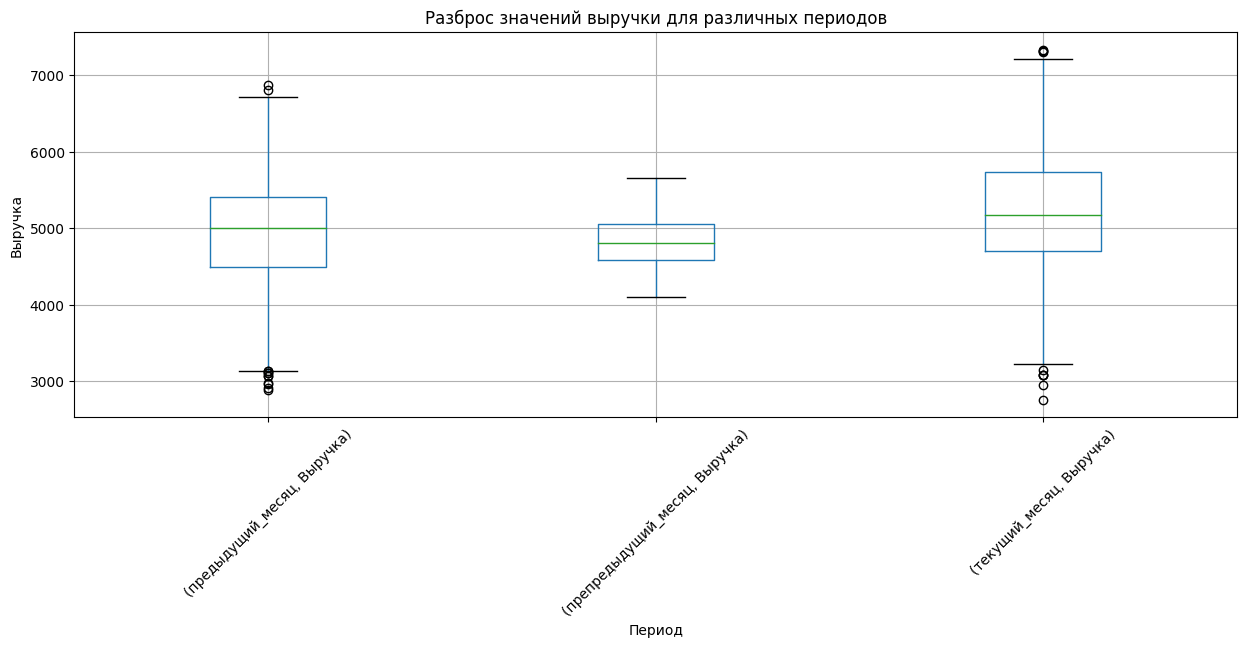

In [36]:
upper_income_curr_period= get_upper_mustache(df_current, 'Выручка')
market_money_data= market_money_data.query('((Период=="текущий_месяц") & (Выручка<@upper_income_curr_period))\
| (Период!="текущий_месяц")')
market_money_data= market_money_data.query('Выручка>0')
display(f'Всего записей о выручке: {len(market_money_data)}')
market_money_data.groupby('Период').boxplot(
subplots=False,
column='Выручка', 
rot=45,
figsize=(15,5))
plt.ylabel('Выручка')
plt.xlabel('Период')
plt.title('Разброс значений выручки для различных периодов')
plt.show()

Посчитаем выручку на 1 пользователя

In [37]:
for period in sorted(market_money_data['Период'].unique()):
    income= market_money_data[market_money_data['Период']==period]['Выручка'].sum()
    users=  market_money_data[market_money_data['Период']==period]['id'].count()
    display(f'Выручка на 1 пользователя в период {period} составляет {round(income/users,2)}')

'Выручка на 1 пользователя в период предыдущий_месяц составляет 4948.34'

'Выручка на 1 пользователя в период препредыдущий_месяц составляет 4836.37'

'Выручка на 1 пользователя в период текущий_месяц составляет 5219.28'

**Вывод: Распределение частоты значений выручки по форме близко к нормальному, можно (после дополнительной соответствующей проверки) использовать коэффициент коррелияции пирсона и тп методы для нормально распределенных данных. Небольшое количество выбросов с нулевым значением выручки и с запредельным значением в текущем месяце удалено. Выручка растет во времени, как суммарно за период, так и на 1 пользователя. И это не смотря на снижение покупательской активности, которая действительно снизилась в 38% случаев.**

#### Анализ данных о времени на сайте

In [38]:
market_time_data.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


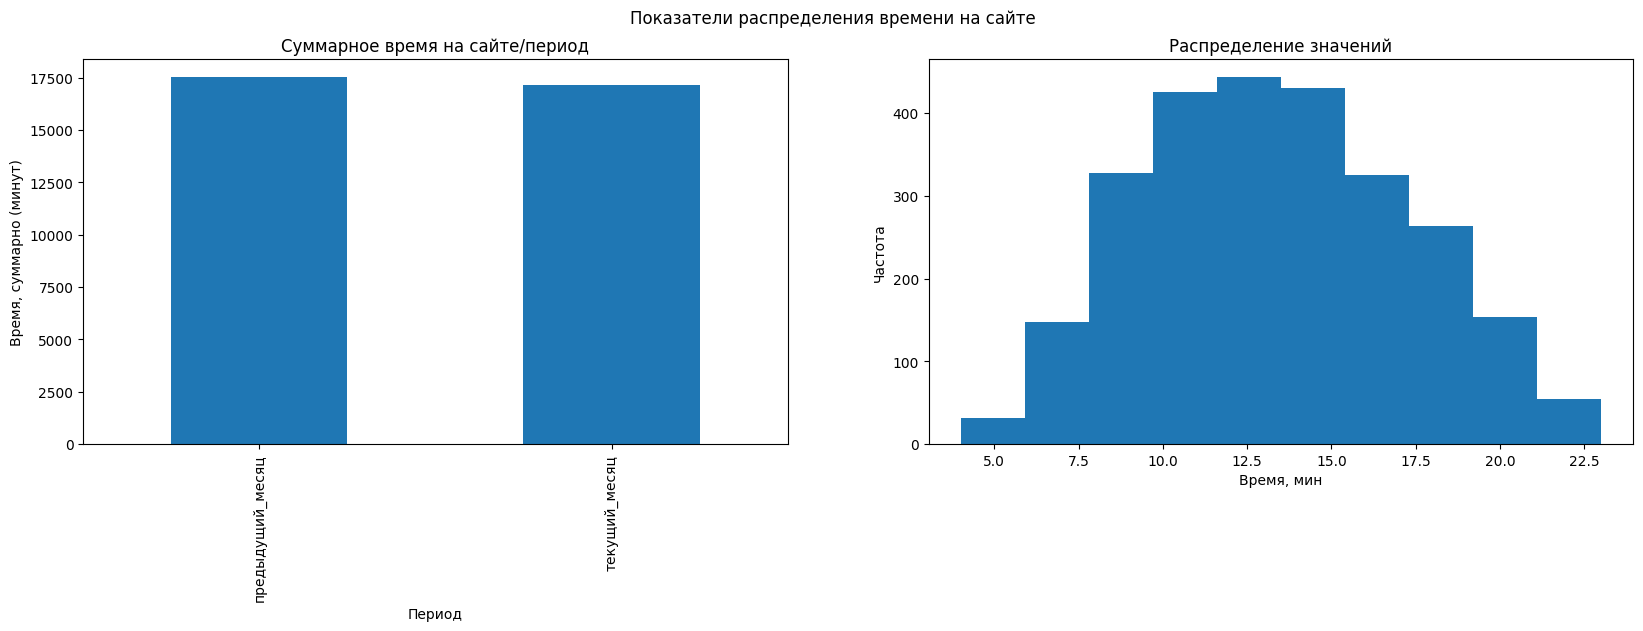

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Показатели распределения времени на сайте')
market_time_data.groupby('Период')['минут'].sum().plot(
kind='bar',
ax=ax1,
title='Cуммарное время на сайте/период')
ax1.set_ylabel('Время, суммарно (минут)')
ax1.set_xlabel('Период')
market_time_data['минут'].plot(
kind='hist',
ax=ax2,
title='Распределение значений')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Время, мин')
plt.show()

Построим ящик с усами для времени на сайте

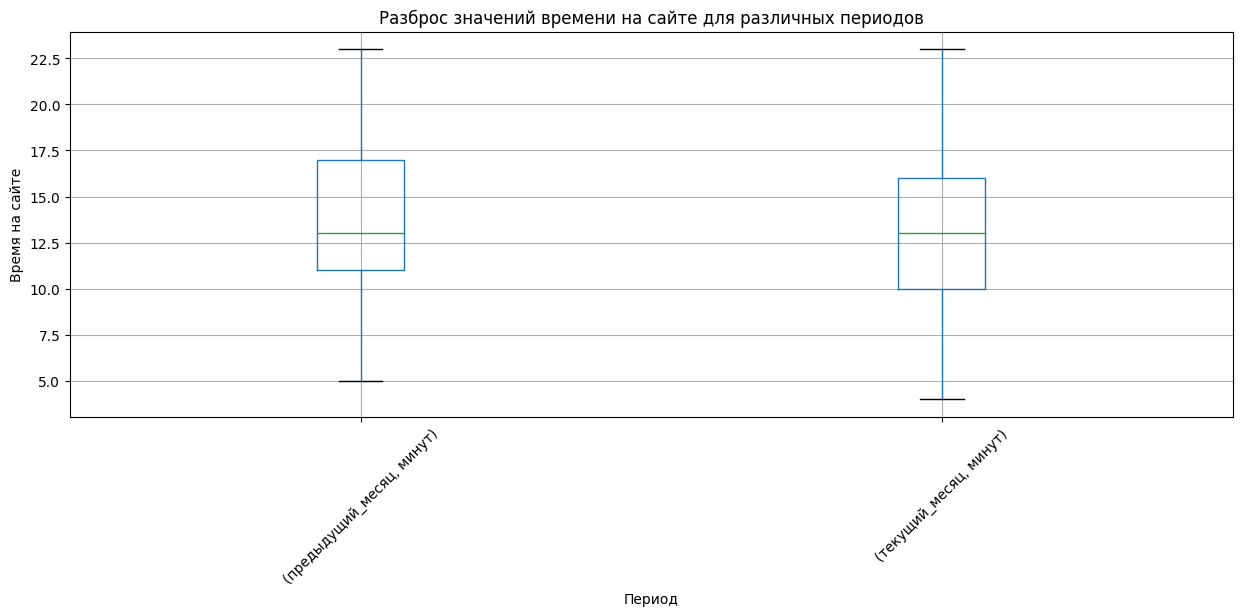

In [40]:
market_time_data.groupby('Период').boxplot(
subplots=False,
column='минут', 
rot=45,
figsize=(15,5))
plt.ylabel('Время на сайте')
plt.xlabel('Период')
plt.title('Разброс значений времени на сайте для различных периодов')
plt.show()

**Вывод: Судя по показателям суммарного времени и разброса, время, проводимое пользователем на сайте, несколько снизилось, что соответствует снижению покупательской активности. Распределение частоты значений времени на сайте по форме близко к нормальному, после соответствующей дополнительной проверки гипотезы о нормальности распределения использовать коэффициент корреляции пирсона и тп методы для нормально распределенных данных.**

#### Анализ данных о прибыли

In [41]:
money_data.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


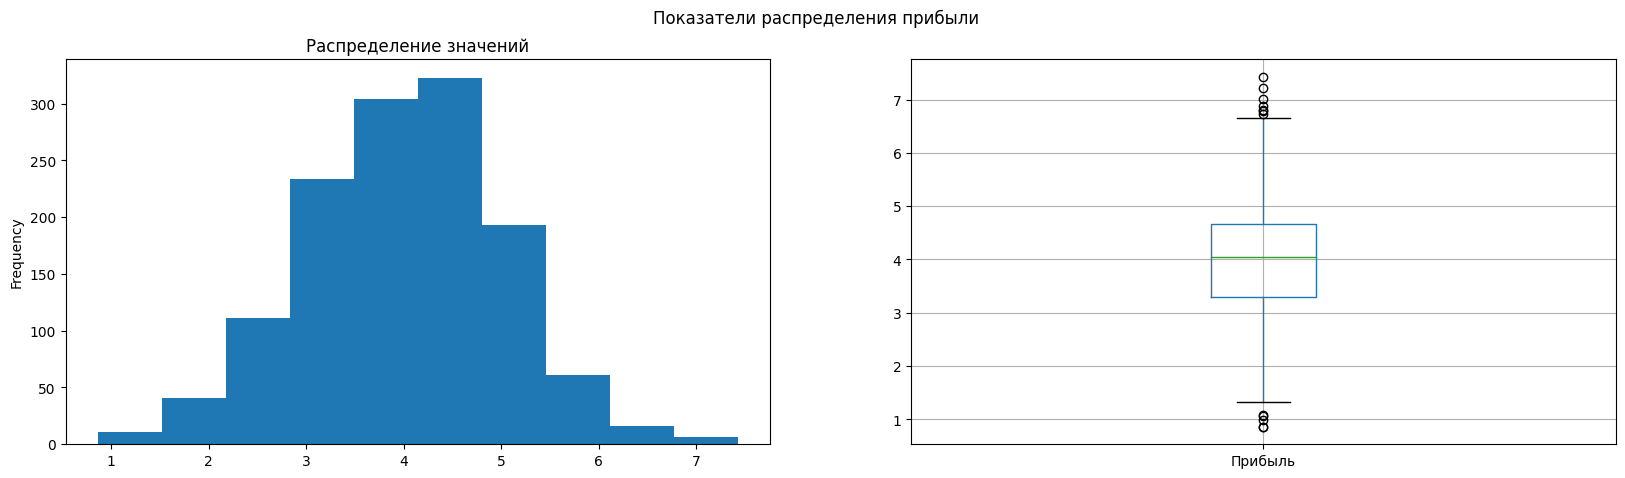

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Показатели распределения прибыли')
money_data['Прибыль'].plot(
ax=ax1,
kind='hist',
ylabel='Частота',
xlabel='Время, мин',
title='Распределение значений')
money_data.boxplot(
ax=ax2, 
column='Прибыль'
)
plt.show()

In [43]:
anomal_values_upper_cnt=get_upper_values_cnt(money_data, 'Прибыль')
anomal_values_lower_cnt=get_lower_values_cnt(money_data, 'Прибыль')
display(f'Количество аномально высоких значений признака "Прибыль" составляет {anomal_values_upper_cnt}')
display(f'то есть {round(100*anomal_values_upper_cnt/len(money_data), 2)}% данных')#значение в % от общего объема выборки
display(f'Количество аномально низких значений признака "Прибыль" составляет {anomal_values_lower_cnt}')
display(f'то есть {round(100*anomal_values_lower_cnt/len(money_data), 2)}% данных')#значение в % от общего объема выборки

'Количество аномально высоких значений признака "Прибыль" составляет 7'

'то есть 0.54% данных'

'Количество аномально низких значений признака "Прибыль" составляет 5'

'то есть 0.38% данных'

Так как высокая прибыль в районе 7 у.е. или низкая в районе 1 у.е. не является невероятным (или ошибочной), не будем удалять данные 

**Вывод: распределение частоты значений прибыли по форме близко к нормальному. Выбросы в данных не обнаружены, аномально высокие или аномально низкие значения составляют небольшую часть данных (менее 1%)** 

#### Отбор клиентов с покупательской активностью не менее 3 месяцев

In [44]:
display(f'Всего записей в таблице с маркетинговыми данными: {len(market_file_data)}')

'Всего записей в таблице с маркетинговыми данными: 1286'

In [45]:
display(f'Записей в таблице с маркетинговыми данными с учетом покупательской активности за 3 месяца: \
{len(market_file_data["id"].isin(market_money_data["id"]))}')

'Записей в таблице с маркетинговыми данными с учетом покупательской активности за 3 месяца: 1286'

In [46]:
display(f'Всего клиентов в таблице с маркетинговыми данными: {len(market_file_data["id"].unique())}')

'Всего клиентов в таблице с маркетинговыми данными: 1286'

In [47]:
display(f'Всего клиентов в таблице с данными о выручке: {len(market_money_data["id"].unique())}')

'Всего клиентов в таблице с данными о выручке: 1300'

**Вывод: так как в таблице с данными о выручке остались только записи о ненулевой выручке за последние 3 месяца, все покупатели из маркетинговой таблицы делали покупки за последние 3 месяца, их отобрано 1251**

#### Общий вывод: судя по собранным данным, в 38% случаев покупательская активность действительно снизилась. Распределение данных для числовых признаков по форме близко к нормальному, кроме признаков, описывающих продуктовое поведение ("доля покупок по акции" и "количество неоплаченных товаров" по форме не соответствуют нормльному распределению). Всего данных с покупательской активностью собрано для 1251 клиента, что достаточно для дальнейшего анализа.

## Объединение таблиц

In [48]:
market_file_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [49]:
market_money_data.head()

,id,Период,Выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0


Добавим столбцы, соответствующие периодам в таблицы о выручке 

In [50]:
period_income_columns=[]
for period in sorted(market_money_data['Период'].unique()):
    period_income_column='Выручка_'+period
    market_money_data[period_income_column]= market_money_data[market_money_data['Период']==period]['Выручка']
    period_income_columns.append(period_income_column)
market_money_data.head()

,id,Период,Выручка,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
1,215348,текущий_месяц,3293.1,NaN,NaN,3293.1
3,215349,препредыдущий_месяц,4472.0,NaN,4472.0,NaN
4,215349,текущий_месяц,4971.6,NaN,NaN,4971.6
5,215349,предыдущий_месяц,5216.0,5216.0,NaN,NaN
6,215350,препредыдущий_месяц,4826.0,NaN,4826.0,NaN


In [51]:
market_money_data_pivot= market_money_data.pivot_table(index=['id'], values=period_income_columns)
market_money_data_pivot.head()

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [52]:
market_time_data.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


Добавим столбцы, соответствующие периодам в таблицe о времени на сайте

In [53]:
period_time_columns=[]
for period in sorted(market_time_data['Период'].unique()):
    period_time_column='минут_'+period
    market_time_data[period_time_column]= market_time_data[market_time_data['Период']==period]['минут']
    period_time_columns.append(period_time_column)
market_time_data_pivot= market_time_data.pivot_table(index=['id'], values=period_time_columns)
market_time_data_pivot.head()

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13.0,14.0
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0


In [54]:
market_data_full= market_file_data.set_index('id').join(market_money_data_pivot).join(market_time_data_pivot)
display(f'Размер итоговой таблицы: {market_data_full.shape}')
market_data_full.head()

'Размер итоговой таблицы: (1286, 17)'

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13.0,14.0
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0


## Корреляционный анализ

Рассчитаем коэффициенты и визуализируем корреляции Спирмана (так как не все данные распределены согласно нормальному закону) между всеми численными признаками в market_data_full

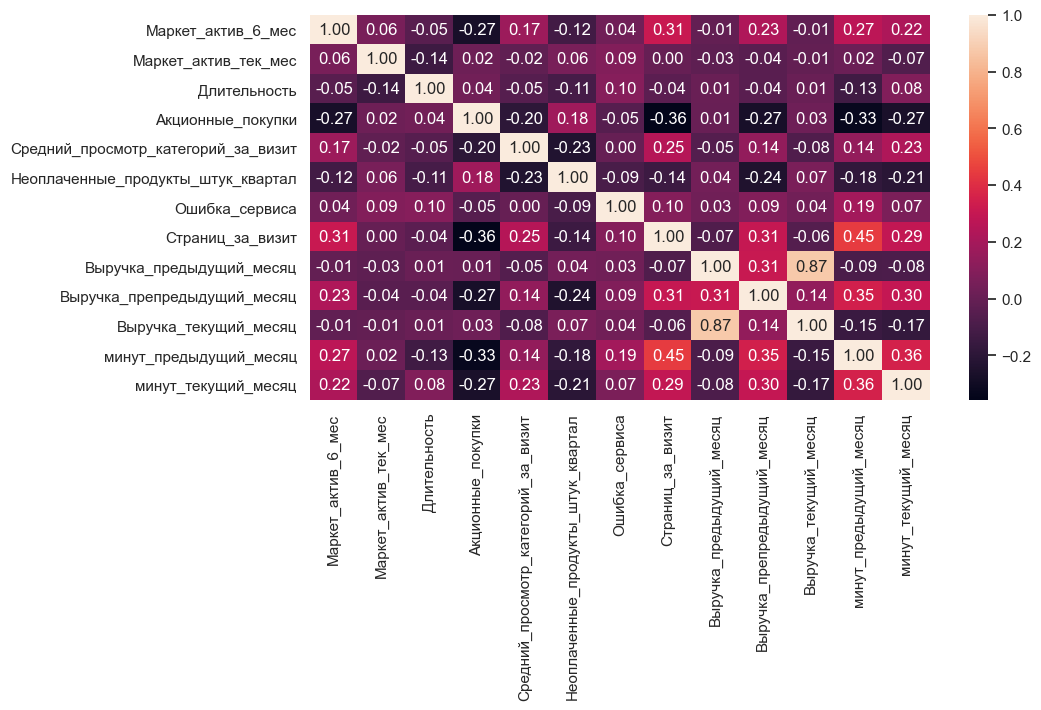

In [55]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(market_data_full.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f') 
plt.show()

Построим матрицу корреляций Phi_K, которая позволяет включить в анализ категориальные признаки, в том числе целевой "Покупательская активность"

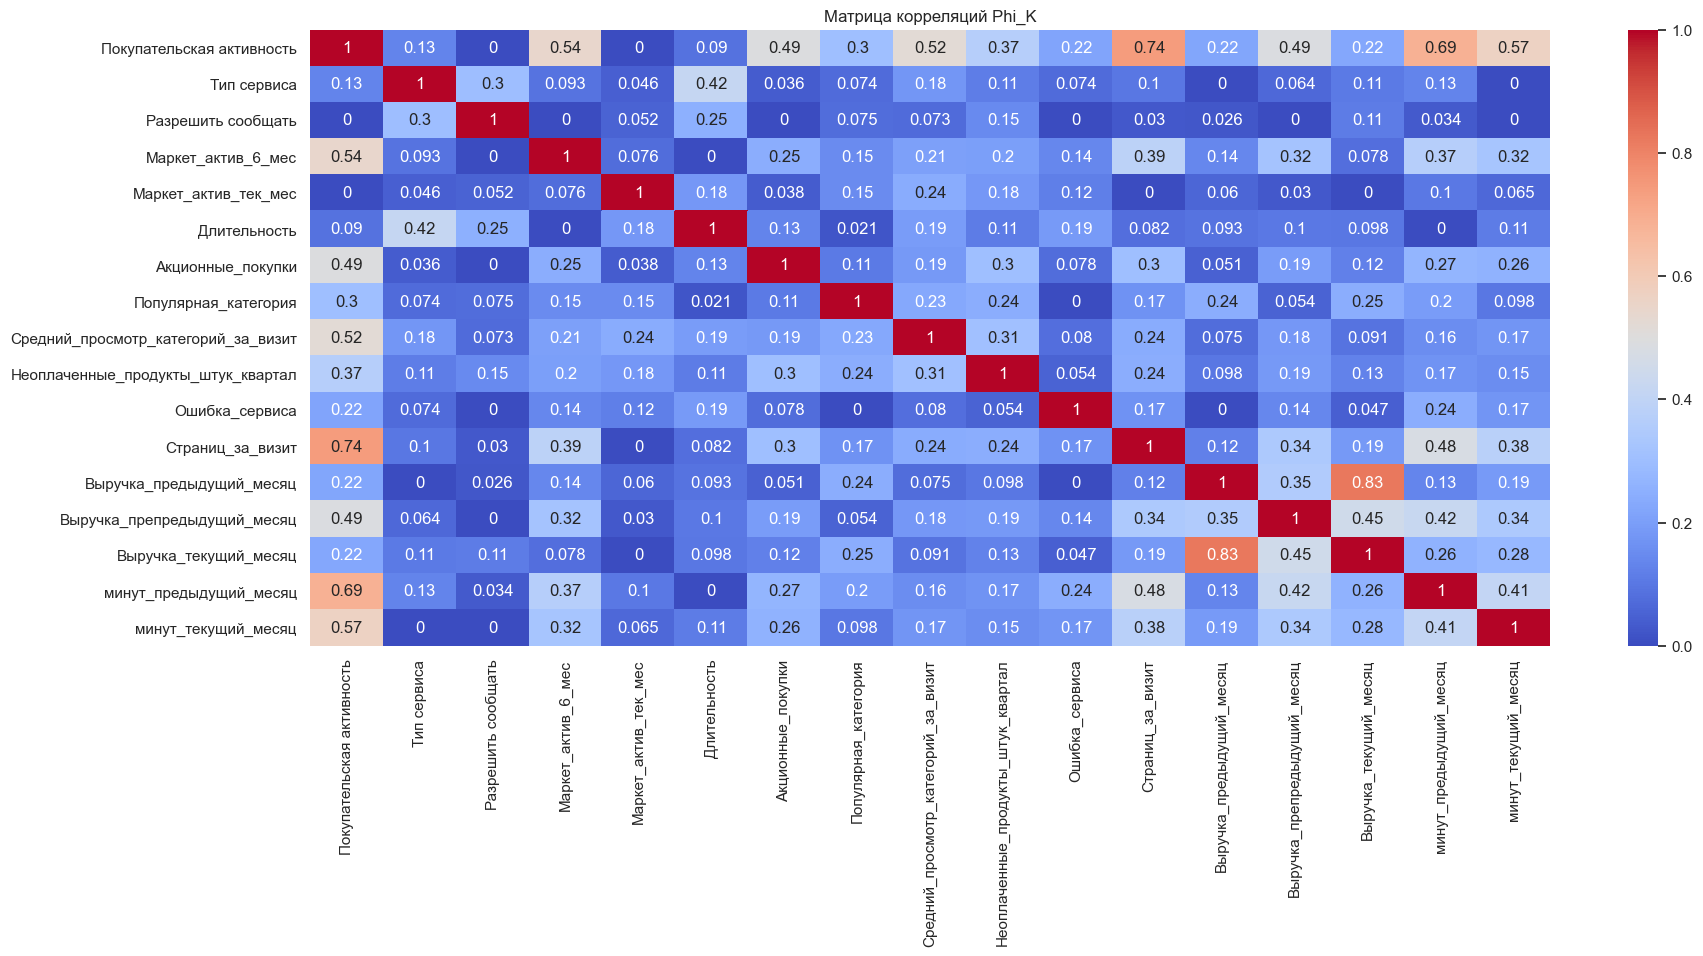

In [56]:
interval_columns=  ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',\
                    'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',\
                    'Страниц_за_визит','Выручка_предыдущий_месяц','Выручка_препредыдущий_месяц','Выручка_текущий_месяц',\
                    'минут_предыдущий_месяц', 'минут_текущий_месяц']
corr_matrix = market_data_full.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K')
plt.show()

**Выводы: так как значение коэффициента корреляции Спирмана для всех пар признаков не превышает 0,9 по модулю, можно говорить об отсутствии мультиколлинеарности. Однако между признаками "Выручка_текущий_месяц" и "Выручка_предыдущий месяц" наблюдается сильная прямая корреляция, поэтому один из этих признаков можно считать кандидатом на удаление чтобы попробовать улучшить показатели моделей, которые будут построены для получения предсказания снижения покупательской активности. Матрица корреляции Phi_k показывает полное отсутствие корреляции между маркетинговой активностью в текущем месяце и целевым признаком, что сильно странно: возможно, это повод проанализировать эту активность на ее эффективность, хотя возможно данные о текущей активности обусловлены активностью предыдущего периода (с которой есть положительная корреляция), а текущая маркетинговая активность скажется в будущем.**

## Использование пайплайнов

Проанализируем количество пропусков в финальной таблице чтоб понимать, надо ли с ними бороться

In [57]:
market_data_full.isna().sum()

Покупательская активность               0
Тип сервиса                             0
Разрешить сообщать                      0
Маркет_актив_6_мес                      0
Маркет_актив_тек_мес                    0
Длительность                            0
Акционные_покупки                       0
Популярная_категория                    0
Средний_просмотр_категорий_за_визит     0
Неоплаченные_продукты_штук_квартал      0
Ошибка_сервиса                          0
Страниц_за_визит                        0
Выручка_предыдущий_месяц                3
Выручка_препредыдущий_месяц             3
Выручка_текущий_месяц                  11
минут_предыдущий_месяц                  0
минут_текущий_месяц                     0
dtype: int64

Удалим пропуски есть в численных данных так как большинство используемых в работе моделей не умеют работать со значениями NaN, а таких записей менее 1,5%

In [58]:
market_data_full= market_data_full.dropna()
print(f'Осталось записей с пропусками: {market_data_full.isna().sum().sum()}')

Осталось записей с пропусками: 0


Задаем значения доли тестовых и тренировочных данных, RANDOM_STATE, разделяем данные на тренировочную и тестовую выборки

In [59]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_data_full.drop(['Покупательская активность'], axis=1),
    market_data_full['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_data_full['Покупательская активность'])

X_train.shape, X_test.shape

((954, 16), (318, 16))

In [60]:
print('y_test:', y_train.head())
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучим модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

print(pd.DataFrame(y_train).head())

y_test: id
216556    Прежний уровень
215887    Прежний уровень
216472    Прежний уровень
215816          Снизилась
215606          Снизилась
Name: Покупательская активность, dtype: object
   0
0  0
1  0
2  0
3  1
4  1


создаём список категориальных признаков

In [61]:
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
ohe_columns = ['Популярная_категория']

создаём список численных признаков 

In [62]:
num_columns=  ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',\
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',\
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц',\
               'Выручка_препредыдущий_месяц','Выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [63]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и OrdinalEncoder-кодирование
ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
)

In [64]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', [StandardScaler(), MinMaxScaler(), 'passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [65]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,5),
        'models__max_features': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 5),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE
        )],
        'models__kernel': ['linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


Выберем метрику "F1" для анализа лучшей модели, так как исходные данные не сбалансированы (например, соотношение значений признаков "тип сервиса" и "наличие разрешения на рассылку" в районе 1:3 и 1:4, а соотношение целевого признака "покупательская активность" примерно 60/40), и эта метрика предпочтительнее ROC-AUC в случае несбалансированных классов. При этом, в случае неверно сделанного персонализированного предложения активность клиентов не увеличится (а то и уменьшится тк "надоели беспокоить попусту"), но и охват не всей целевой аудитории для персональных предложений тоже нежелателен, то есть метрики Precision и Recall важны в равной степени.  

In [66]:
cv_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
cv_search.fit(X_train, y_train)

print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', cv_search.best_score_)

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                            

Проверим работу модели на тестовой выборке

In [67]:
y_test_pred = cv_search.predict(X_test)
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика F1 на тестовой выборке: 0.8138528138528138


<b>Вывод:</b>
<ol>
<li>Построен пайплайн, включающий кодирование с помощью OneHotEncoder и OrdinalEncoder категориальных признаков и масштабирование численных признаков с помощью StandardScaler и MinMaxScaler</li>
<li>Построен общий пайплайн, позволяющий с помощью кросс-валидации в RandomizedSearchCV перебирать гиперпараметры моделей DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC</li>
<li>В качестве метрики выбрана F1 так как исходные данные не сбалансированы, а метрики Precision и Recall важны в равной степени исходя из задач удержания клиентов и повышения их активности</li>
<li>В результате моделирования лучшие показатели у модели LogisticRegression с параметрами C=3, penalty='l1', random_state=42, solver='liblinear' (значение метрики F1 на тренировочной выборке 0.82, на тестовой 0.81)</li>
</ol>

## Анализ важности признаков

Построим график общей значимости признаков

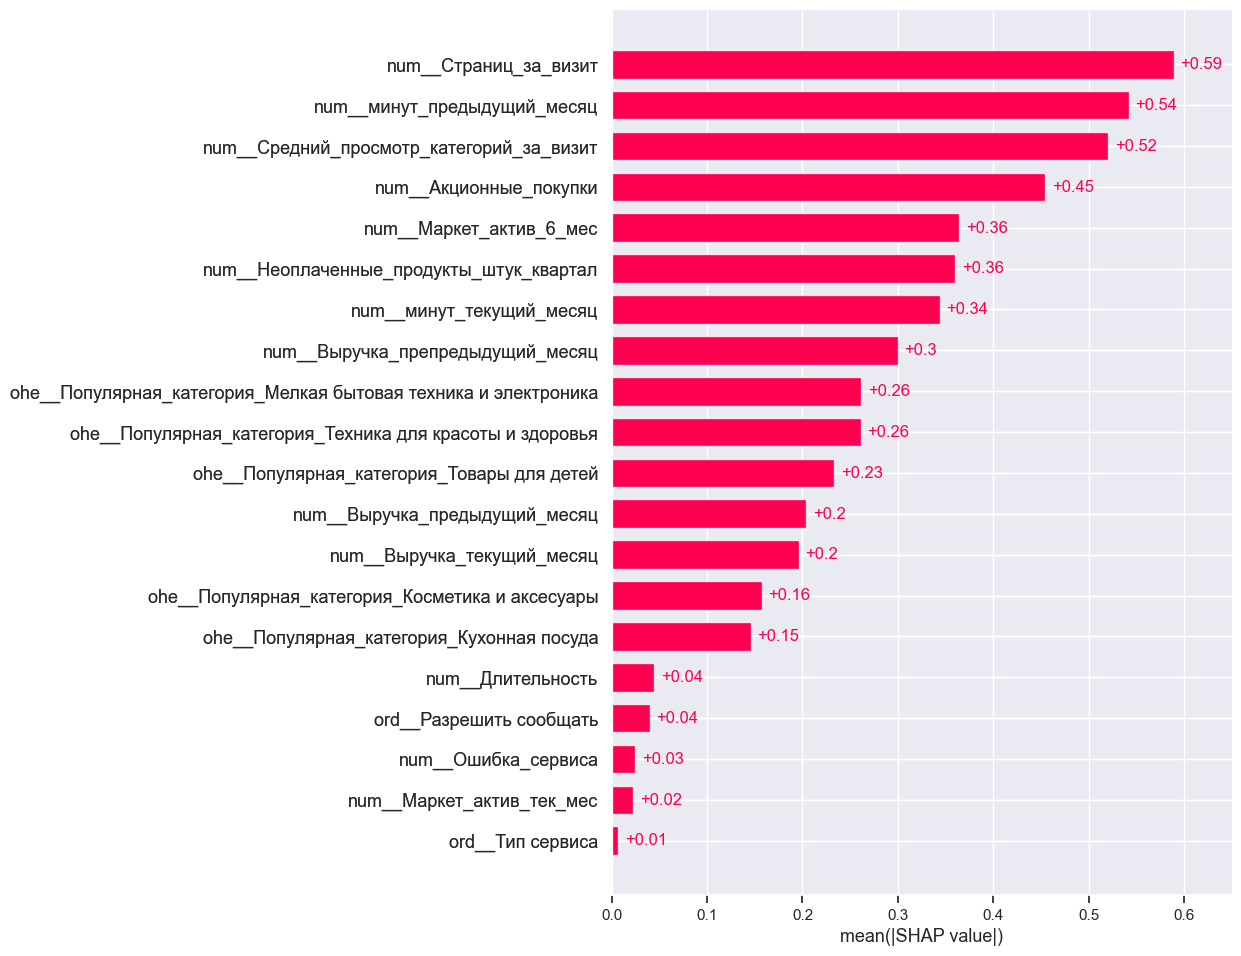

In [68]:
feature_names= cv_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_train_transformed = cv_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = cv_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
explainer = shap.LinearExplainer(cv_search.best_estimator_.named_steps['models'], X_train_transformed)
explainer.feature_names= feature_names
shap_values = explainer(X_train_transformed)
shap.plots.bar(shap_values, max_display=21) 

Посмотрим, как признаки влияют на каждое предсказание модели

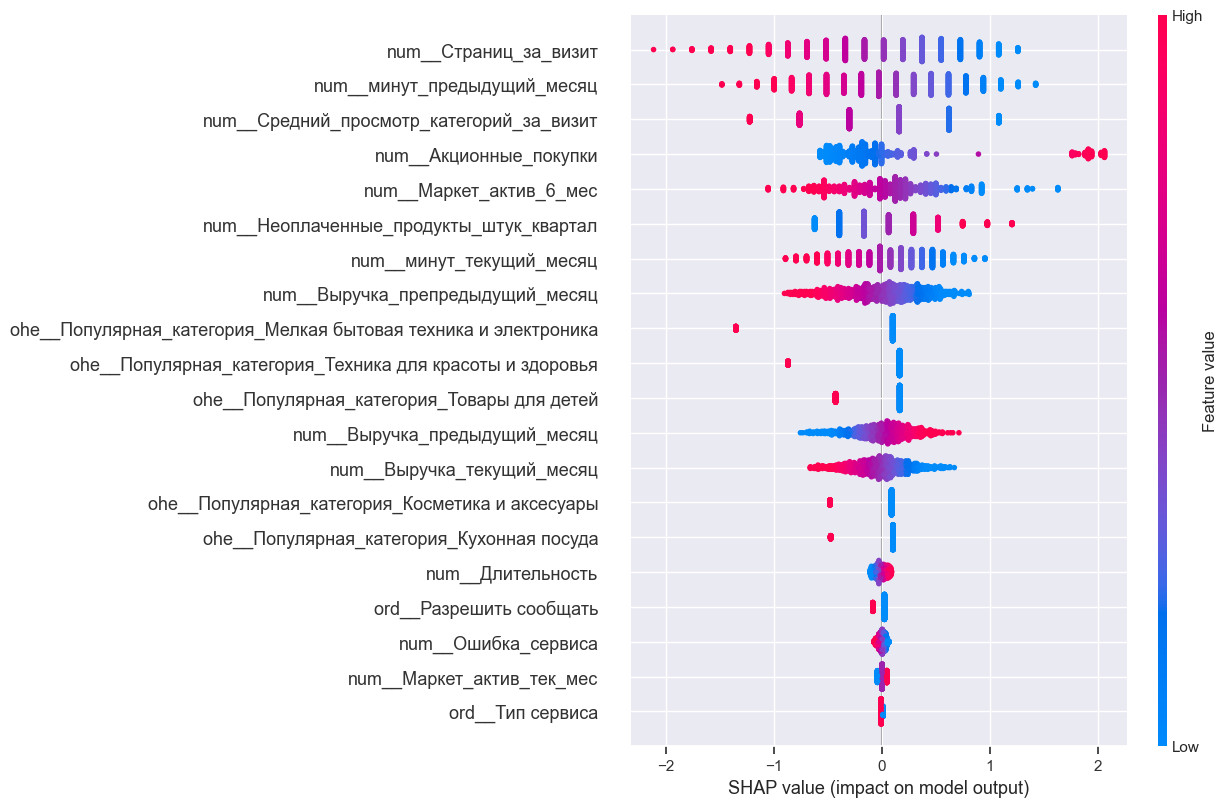

In [69]:
shap.plots.beeswarm(shap_values, max_display=21) 

**Вывод: наиболее значимыми для модели (сильнее всего влияют на целевой признак) являются: количество времени, проведенное на сайте в предыдущем месяце, средний просмотр категорий и страниц за визит, количество акционных покупок. Практически не значимыми для модели являются признаки разрешения на рассылку маркетинговых сообщений, тип сервиса (обычный или премиум), количество ошибок сервиса. Не сильно значимым также является количество маркетинговых коммуникаций в текущем месяце. 
Интересным является влияние признака "доля акционных покупок" на снижение активности клиентов: судя по графику, чем больше покупок клиент делает по акции, тем более вероятно снижение его активности (что выглядит не очень логично с точки зрения житейского опыта), при этом чем выше общее число маркетинговых контактов - тем вероятность снижения активности ниже, а чем выше количество неоплаченных товаров - тем вроятность выше (то и другое логично). Из графика также видны категории, наиболее снижающие вероятность снижения покупательской активности, их можем использовать при моделировании для разработки персонализированных предложений клиентам. При принятии бизнес-решений можно также заключить, что нет смысла много усилий тратить на улучшение стабильности сайта или усиление работы с премиум клиентами (или увеличения их количества) из-за малого влияния на целевой признак. Зато на удержание посетителя сайта на интересующих его страницах стоит сосредоточиться, и, определив, что наиболее интересует клиентов, развивать эту область.**

## Сегментация покупателей

Сбросим индекс чтобы предсказанные значения можно было добавить в таблицу по порядковому номеру записи

In [70]:
market_data_full= market_data_full.reset_index()
market_data_full.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


Получим предсказанные по лучшей модели вероятности снижения покупательской активности

In [71]:
y_proba_data = pd.DataFrame(data= cv_search.best_estimator_.predict_proba(market_data_full)[:,1], columns = ['y_proba']).\
sort_values(by='y_proba',ascending=False)
y_proba_data.head()

,y_proba
331,0.999313
66,0.998493
177,0.998485
335,0.998350
108,0.998100


Добавим вероятность снижения покупательской активности в общую таблицу

In [72]:
market_data_full= market_data_full.join(y_proba_data)
market_data_full.sort_values(by='y_proba',ascending=False).head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_proba
331,215701,Снизилась,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9.0,7.0,0.999313
66,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3,5943.5,4661.0,6427.1,8.0,11.0,0.998493
177,215538,Снизилась,премиум,да,1.5,5,788,0.89,Товары для детей,1,4,4,4,6013.5,4641.0,6900.1,8.0,4.0,0.998485
335,215705,Снизилась,премиум,нет,0.9,4,657,0.99,Домашний текстиль,2,4,2,5,5055.5,4568.0,5522.2,10.0,7.0,0.998350
108,215463,Снизилась,стандарт,нет,3.1,4,472,0.99,Домашний текстиль,2,6,3,3,5196.0,4470.0,5015.3,8.0,12.0,0.998100


Добавим прибыль для каждого покупателя в общую таблицу

In [73]:
market_data_full= market_data_full.set_index('id').join(money_data.set_index('id'))
market_data_full.sort_values(by='y_proba',ascending=False).head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_proba,Прибыль
id,,,,,,,,,,,,,,,,,,,
215701,Снизилась,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9.0,7.0,0.999313,5.05
215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3,5943.5,4661.0,6427.1,8.0,11.0,0.998493,4.98
215538,Снизилась,премиум,да,1.5,5,788,0.89,Товары для детей,1,4,4,4,6013.5,4641.0,6900.1,8.0,4.0,0.998485,2.79
215705,Снизилась,премиум,нет,0.9,4,657,0.99,Домашний текстиль,2,4,2,5,5055.5,4568.0,5522.2,10.0,7.0,0.998350,4.30
215463,Снизилась,стандарт,нет,3.1,4,472,0.99,Домашний текстиль,2,6,3,3,5196.0,4470.0,5015.3,8.0,12.0,0.998100,3.08


Построим диаграмму разброса прибыли и вероятности снижения покупательской активности клиентов

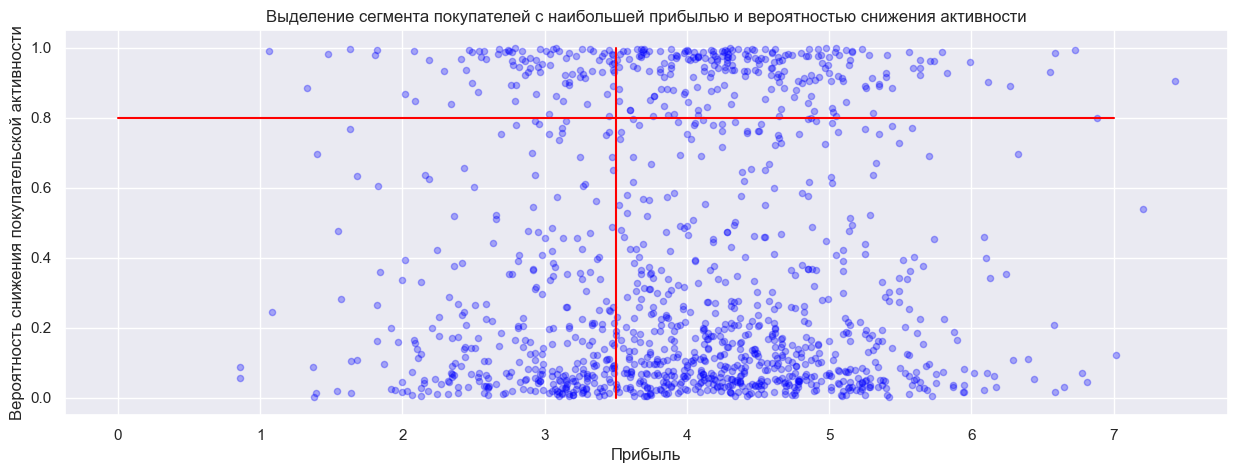

Коэффициент корреляции: 0.012


In [74]:
fig, ax = plt.subplots(figsize=(15,5))
market_data_full.plot(
    ax=ax,
    x='Прибыль', 
    y='y_proba',
    xlabel='Прибыль',
    kind='scatter',
    ylabel='Вероятность снижения покупательской активности',
    title='Выделение сегмента покупателей с наибольшей прибылью и вероятностью снижения активности',
    alpha=0.3,
    color='blue'
)
ax.plot(np.linspace(0, 7), np.linspace(0.8, 0.8), color='red')
ax.plot(np.linspace(3.5, 3.5), np.linspace(1, 0), color='red')
plt.show()
cc= market_data_full['Прибыль'].corr(market_data_full['y_proba'])
print(f'Коэффициент корреляции: {round(cc, 3)}')

Отберем покупателей, соответствующих диаграмме (для 80% которых наиболее вероятно снижение активности, при этом приносят более 3.5 единиц прибыли), при этом выручка в текущем месяце уже ниже предыдущего (то есть предсказание о снижении активности уже начинает сбываться)

In [75]:
market_data_segment= market_data_full.query('Прибыль>3.5 & y_proba>0.8 & Выручка_предыдущий_месяц>Выручка_текущий_месяц')
print(f'Всего отобрано {len(market_data_segment)} клиентов')
market_data_segment.head()

Всего отобрано 44 клиентов


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_proba,Прибыль
id,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,0.915606,4.16
215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,5823.0,4536.0,5591.6,11.0,9.0,0.889810,6.27
215374,Снизилась,стандарт,нет,2.9,5,268,0.98,Домашний текстиль,6,3,2,2,5762.5,4666.0,5720.9,11.0,8.0,0.975353,4.08
215389,Снизилась,премиум,да,4.1,3,1047,0.93,Товары для детей,5,2,3,7,4550.0,4484.0,4429.1,7.0,7.0,0.941604,4.60
215391,Снизилась,премиум,да,3.5,3,754,0.30,Косметика и аксесуары,3,1,2,1,5928.5,4556.0,5824.5,10.0,11.0,0.886403,5.44


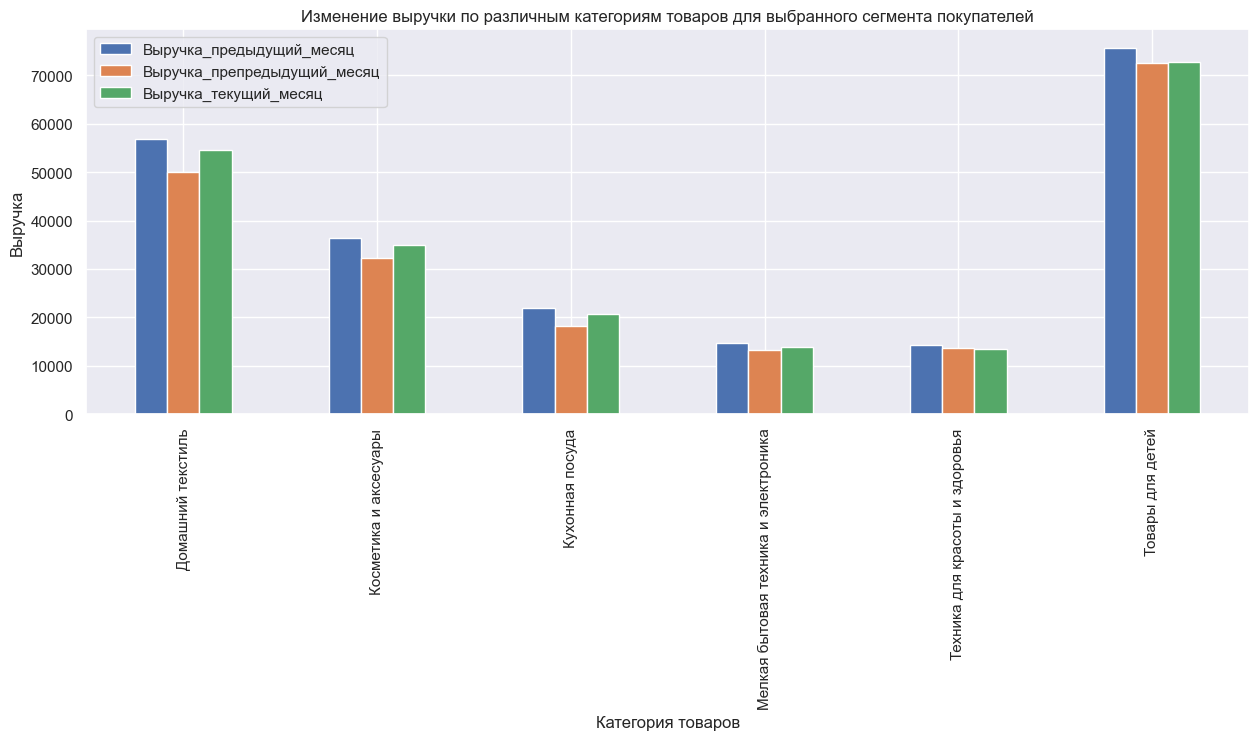

In [76]:
market_data_segment.pivot_table(index='Популярная_категория', values= ['Выручка_препредыдущий_месяц',\
                                                                       'Выручка_предыдущий_месяц','Выручка_текущий_месяц'],\
                                                                        aggfunc='sum').plot(
figsize=(15,5),
kind='bar',
xlabel='Категория товаров',
ylabel='Выручка',
title='Изменение выручки по различным категориям товаров для выбранного сегмента покупателей')
plt.show()

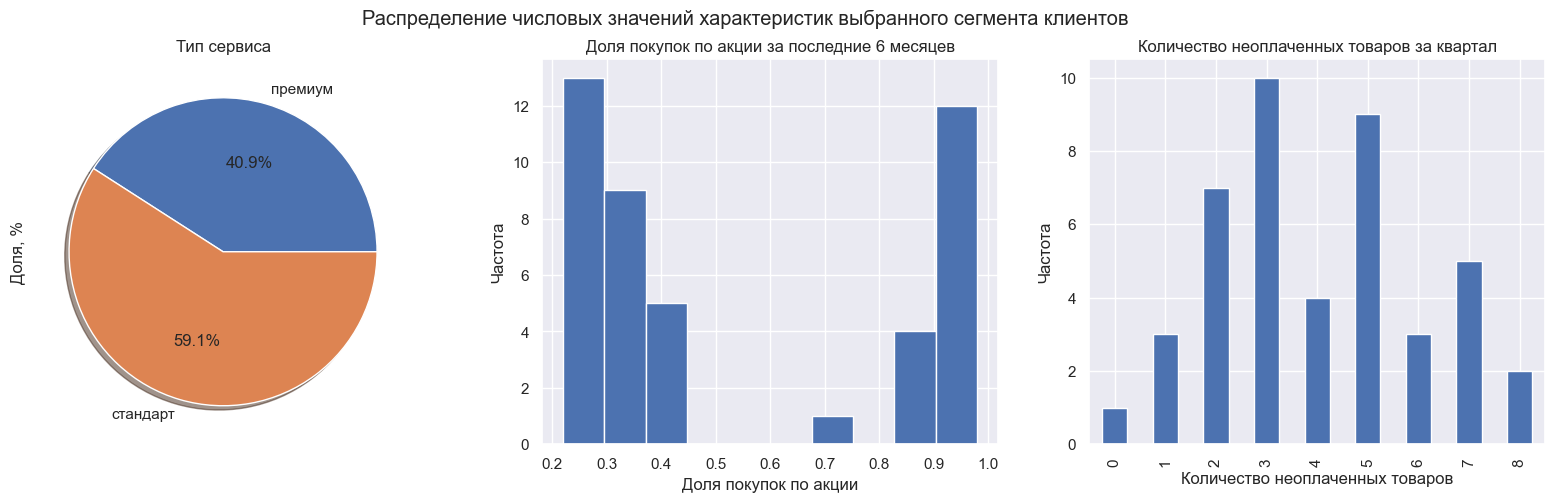

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение числовых значений характеристик выбранного сегмента клиентов')
market_data_segment.groupby('Тип сервиса')['Тип сервиса'].count().plot(
kind='pie',
ax=ax1,
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Тип сервиса')
market_data_segment['Акционные_покупки'].plot(
ax=ax2,
kind='hist',
title='Доля покупок по акции за последние 6 месяцев')
ax2.set_xlabel('Доля покупок по акции')
ax2.set_ylabel('Частота')
market_data_segment.groupby('Неоплаченные_продукты_штук_квартал')['Неоплаченные_продукты_штук_квартал'].count().plot(
ax=ax3,
kind='bar',
title='Количество неоплаченных товаров за квартал')
ax3.set_xlabel('Количество неоплаченных товаров')
ax3.set_ylabel('Частота')
plt.show()

**Вывод: выбранный сегмент покупателей - приносящие наибольшую прибыль, при этом с наибольшей вероятностью будет снижена покупательская активность (что уже подтверждается в текущем месяце). Доля премиум клиентов чуть выше среднего (40/60 против 30/70 в среднем), при этом распределение покупок по акции примерно такое же, что и в среднем, а количество неоплаченных товаров несколько больше среднего. Что касается категорий товаров, то снижение активности примерно равномерное по всем категориям. Исходя из вышеперечисленного, можно предложить в качестве персонализированного предложения для повышения активности вместе с напомнинанием о неоплаченных товарах в корзине предлагать специальные предложения на аналогичные товары.**

## Общий вывод

<b>Задачи:</b>
<ol>
<li>Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца</li>
<li>Выделить сегмент покупателей и предложить, как увеличить его покупательскую активность за счет персонализированных предложений</li>
</ol>
<b>Исходные данные (предобработка и анализ):</b>
<ol>
<li>Признаки, которые описывают коммуникацию сотрудников компании с клиентом.</li>
<li>Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.</li>
<li>Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.</li>
<li>Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте</li>
<li>Данные о выручке по клиентам</li>
<li>Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода</li>
<li>Данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю</li>
</ol>
<p>При предобработке пропусков в данных, явных и неявных дубликатов не обнаружено. Строки-перечисления приведены к единообразному виду.Небольшое количество выбросов в данных с высоким и нулевым значением текущей выручки удалены.</p>
<p>При исследовательском анализе данных выявлено, что большинство данных (исходные признаки) имеют распределение, близкое к нормальному, кроме признаков, описывающих продуктовое поведение ("доля покупок по акции" и "количество неоплаченных товаров" имеют другое распределение). Так как значение коэффициента корреляции Спирмана для всех пар признаков не превышает 0,9 по модулю, можно говорить об отсутствии мультиколлинеарности.</p>
<b>Поиск лучшей модели:</b>
<ol>
<li>Построен пайплайн, включающий кодирование с помощью OneHotEncoder и OrdinalEncoder категориальных признаков и масштабирование численных признаков с помощью StandardScaler и MinMaxScaler</li>
<li>Построен общий пайплайн, позволяющий с помощью кросс-валидации в RandomizedSearchCV перебирать гиперпараметры моделей DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC</li>
<li>В качестве метрики выбрана F1 так как исходные данные не сбалансированы, а метрики Precision и Recall важны в равной степени исходя из задач удержания клиентов и повышения их активности</li>
<li>В результате моделирования лучшие показатели у модели LogisticRegression с параметрами C=3, penalty='l1', random_state=42, solver='liblinear' (значение метрики F1 на тренировочной выборке 0.82, на тестовой 0.81)</li>
</ol>
<b>Сегментация покупателей и персонализированные предложения для выбранного сегмента:</b>
<ol>
<li>Выбранный сегмент покупателей - приносящие наибольшую прибыль, при этом с наибольшей вероятностью будет снижена покупательская активность, для которых уже подтверждается снижение выручки в текущем месяце.</li>
<li>Персонализированные предложения: для повышения активности вместе с напомнинанием о неоплаченных товарах в корзине предлагать специальные предложения на товары категории, которая была самой популярной у выбранных клиентов в течение 6 месяцев.</li>
</ol>